In [1]:
#tensorflow
import pandas as pd
import numpy as np

In [2]:
train_csv = pd.read_csv('playground-series-s5e5/train.csv')
test_csv = pd.read_csv('playground-series-s5e5/test.csv')

print(train_csv.isnull().sum())
print(test_csv.isnull().sum())

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64
id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64


In [3]:
train_csv.sample(5)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
498855,498855,male,39,189.0,91.0,12.0,86.0,39.8,42.0
297993,297993,male,48,179.0,86.0,7.0,80.0,39.5,18.0
493188,493188,male,44,184.0,88.0,9.0,90.0,40.0,39.0
158524,158524,female,30,164.0,59.0,18.0,94.0,40.5,89.0
269837,269837,male,30,187.0,85.0,2.0,84.0,38.0,7.0


In [4]:
input_features = list(train_csv.columns)
#removeはリストに使う
input_features.remove('id')
input_features.remove('Calories')
print(f'Input Features:{input_features}')

Input Features:['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']


In [5]:
train_csv[input_features]

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,male,36,189.0,82.0,26.0,101.0,41.0
1,female,64,163.0,60.0,8.0,85.0,39.7
2,female,51,161.0,64.0,7.0,84.0,39.8
3,male,20,192.0,90.0,25.0,105.0,40.7
4,female,38,166.0,61.0,25.0,102.0,40.6
...,...,...,...,...,...,...,...
749995,male,28,193.0,97.0,30.0,114.0,40.9
749996,female,64,165.0,63.0,18.0,92.0,40.5
749997,male,60,162.0,67.0,29.0,113.0,40.9
749998,male,45,182.0,91.0,17.0,102.0,40.3


In [6]:
#ラベルエンコーディング
train_csv["Sex"] = train_csv["Sex"].map({"male":0,"female":1})
test_csv["Sex"] = test_csv["Sex"].map({"male":0,"female":1})

In [7]:
X = train_csv[input_features].values
Y = train_csv['Calories'].values

In [8]:
#正規化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [9]:
#分割
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=.8,random_state=0)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Kfoldで分割してRobustScalerでスケーリング
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import RobustScaler

# kf = KFold(n_splits=3,shuffle=True,random_state=42)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import EarlyStopping

#モデル定義（Sequential:単純にそうを積み重ねる一番単純なモデル)
model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),#入力層：入力次元は訓練データの列数
    layers.Dense(128,activation='relu'),#第一隠れ層
    layers.Dense(64,activation='relu'),#第二隠れ層
    layers.Dense(32,activation='relu'),#第三隠れ層
    layers.Dense(1,activation='relu')#出力層：１ユニット（予測対象）、reluで負の値を防止
    ])

    #損失関数定義
def rmsle(y_true,y_pred):
    #極端な値を防ぐためにclip(0~最大値)
    y_true = tf.clip_by_value(y_true,0,tf.reduce_max(y_true))
    y_pred = tf.clip_by_value(y_pred,0,tf.reduce_max(y_pred))
    #RSMLEを手計算(lop1pで対数変換、差の２乗->平均->平方根)
    return tf.sqrt(tf.reduce_mean(tf.square(tf.math.log1p(y_pred)-tf.math.log1p(y_true))))

#モデルのコンパイル(最適化アルゴリズム、損失関数、評価指標を設定)
model.compile(
    optimizer='adam',#学習率調整も自動なAdam最適化
    loss=rmsle,#損失関数
    metrics=['mae'])#評価指標としてMAE(平均絶対誤差)も見る

#val_lossが改善しない場合、5回で停止し最良の重みに戻す
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5, restore_best_weights=True)

#モデルの学習
model.fit(
    X_train_scaled,#入力データ(正規化済み)
    Y_train,#正解ラベル
    validation_data = (X_test_scaled,Y_test),#検証データ(val_loss用)
    epochs=50,#最大50エポックまで学習
    batch_size=32,#１バッチあたり32サンプル
    callbacks=[early_stop],#早期終了を使う
    verbose=1
    )

test_csv_scaled = scaler.transform(test_csv[input_features].values)
y_pred = model.predict(X_test_scaled).flatten()
y_pred_t = model.predict(test_csv_scaled)

Epoch 1/50
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.3147 - mae: 12.0175 - val_loss: 0.0619 - val_mae: 2.4837
Epoch 2/50
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0637 - mae: 2.5316 - val_loss: 0.0618 - val_mae: 2.6494
Epoch 3/50
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0621 - mae: 2.4719 - val_loss: 0.0610 - val_mae: 2.3780
Epoch 4/50
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0620 - mae: 2.4377 - val_loss: 0.0619 - val_mae: 2.3053
Epoch 5/50
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0605 - mae: 2.4025 - val_loss: 0.0637 - val_mae: 3.1794
Epoch 6/50
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0610 - mae: 2.4198 - val_loss: 0.0573 - val_mae: 2.2103
Epoch 7/50
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0599 - mae: 2.3632 - val_loss: 0.0574 - val_mae: 2.4118
Epoch 8/50
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0595 - mae: 2.3738 - val_loss: 0.0652 - val_mae: 2.2582
Epoch 9/50
4688/4688 ━━━━━━━━━━━━━━━━━━

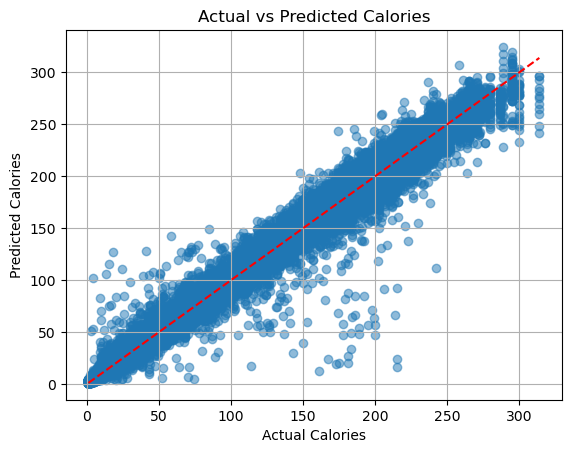

In [11]:
import matplotlib.pyplot as plt
plt.scatter(Y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Calories")
plt.ylabel("Predicted Calories")
plt.title("Actual vs Predicted Calories")
plt.plot([Y_test.min(), Y_test.max()],[Y_test.min(), Y_test.max()], 'r--')
plt.grid(True)
plt.show()

In [12]:
submission = pd.DataFrame({
    'id':test_csv['id'],
    'Calories':y_pred_t.flatten()
})

In [13]:
submission.to_csv("submission1.csv",index=False)

In [14]:
submission[submission["Calories"]<0]

,id,Calories
